In [2]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
RESULTS_DIR = '../results'

In [6]:
def make_har_json_name(url, is_http2):
    # Convert the url + is_http2 into the name of the har json file.
    return f"har_file_{url.split('/')[-1]}_{'http1' if not is_http2 else 'http2'}.json"

def load_test_files():
    # Load in the files that configured the test (after which the har json is named for).
    with open('../image_test_files.json') as f:
        test_files = json.loads(f.read())
    return test_files

def load_har_file_per_test_to_df(file_obj, test_num):
    # For every har json file, load the timings of the image fetches into a datafram.
    har_name = make_har_json_name(file_obj['url'], file_obj['is_http2'])
    with open(f"{RESULTS_DIR}{str(test_num)}/{har_name}", 'r') as f:
        har_log = json.loads(f.read())['log']
    url_to_check = file_obj['url'] if 'ome.tif' in file_obj['url'] else file_obj['url'] + '/data.zarr'
    image_entry_timings = [
        entry["timings"] for entry in har_log["entries"] if file_obj['url'] in entry["request"]["url"]
    ]
    image_entry_total = [
        entry["time"] for entry in har_log["entries"] if file_obj['url'] in entry["request"]["url"]
    ]
    df_image = pd.json_normalize(image_entry_timings)
    df_image['url'] = file_obj['url']
    df_image['test'] = test_num
    df_image['is_http2'] = file_obj['is_http2']
    df_image['type'] = file_obj['type']
    df_image['tile_size'] = file_obj['tile_size']
    df_image['total_time'] = image_entry_total
    return df_image

In [7]:
# Load all har json files into one large dataframe, df.
df = pd.DataFrame()
test_files = load_test_files()
for test_num in range(20):
    for file_info in test_files:
        df_image = load_har_file_per_test_to_df(file_info, test_num)
        df = df.append(df_image, ignore_index=True)

In [8]:
df = df.set_index(['type', 'tile_size', 'is_http2'])
df

blocked     dns      ssl  connect   send     wait  \
type tile_size is_http2                                                      
tiff 1024      False      -0.929  23.207  247.312  292.691  0.111   22.565   
               False     316.504  -1.000   -1.000   -1.000  0.051   55.586   
               False       0.644  -1.000   -1.000   -1.000  0.121   41.113   
               False       0.563  -1.000   -1.000   -1.000  0.167   31.896   
               False      57.947  -1.000   -1.000   -1.000  0.051   27.058   
...                          ...     ...      ...      ...    ...      ...   
zarr 256       True        0.460  -1.000   -1.000   -1.000  0.107  877.421   
               True        0.612  -1.000   -1.000   -1.000  0.147  456.467   
               True        0.545  -1.000   -1.000   -1.000  0.146  456.223   
               True        0.487  -1.000   -1.000   -1.000  0.142  455.834   
               True        0.452  -1.000   -1.000   -1.000  0.105  455.486   

                          receive  _blocked_queueing  \
type tile_size is_http2                                
tiff 1024      False        0.285             -1.000   
               False       29.483            316.302   
               False       25.916              0.405   
               False       25.879              0.296   
               False       29.661              0.445   
...                           ...                ...   
zarr 256       True      1478.159              0.292   
               True      1198.825              0.331   
               True      1198.555              0.297   
               True      1197.232              0.283   
               True      1212.876              0.279   

                                                                       url  \
type tile_size is_http2                                                      
tiff 1024      False     https://http1.viv.vitessce.io/spraggins_1024_z...   
               False     https://http1.viv.vitessce.io/spraggins_1024_z...   
               False     https://http1.viv.vitessce.io/spraggins_1024_z...   
               False     https://http1.viv.vitessce.io/spraggins_1024_z...   
               False     https://http1.viv.vitessce.io/spraggins_1024_z...   
...                                                                    ...   
zarr 256       True            https://http2.viv.vitessce.io/spraggins_256   
               True            https://http2.viv.vitessce.io/spraggins_256   
               True            https://http2.viv.vitessce.io/spraggins_256   
               True            https://http2.viv.vitessce.io/spraggins_256   
               True            https://http2.viv.vitessce.io/spraggins_256   

                         test  total_time  
type tile_size is_http2                    
tiff 1024      False        0     338.859  
               False        0     401.624  
               False        0      67.794  
               False        0      58.505  
               False        0     114.717  
...                       ...         ...  
zarr 256       True        19    2356.147  
               True        19    1656.051  
               True        19    1655.469  
               True        19    1653.695  
               True        19    1668.919  

[85738 rows x 11 columns]

In [10]:
mean_df = df.groupby(['type', 'tile_size', 'is_http2']).agg('mean')
total_df = df.groupby(['type', 'tile_size', 'is_http2']).size()
mean_df['total_requests'] = total_df
mean_df[['blocked', 'wait', 'receive', '_blocked_queueing', 'total_time', 'total_requests']]

blocked        wait       receive  \
type tile_size is_http2                                          
tiff 256       False     1320.189032   56.504393     43.974364   
               True      1188.020671   51.921626     26.626724   
     512       False     1521.865370   76.656192    286.076279   
               True      1854.350281   86.108341     77.440885   
     1024      False     6371.542834   92.038453   1278.665764   
               True      8184.708120  259.697412    301.477161   
zarr 256       False      694.628573   70.942187     72.623675   
               True        22.276780  446.733542    401.556983   
     512       False     2932.268286   87.620336    349.212965   
               True        15.408519  422.171196   3190.160275   
     1024      False     3303.309110   88.678713   1186.786396   
               True         6.985065  440.240736  12081.301708   

                         _blocked_queueing    total_time  total_requests  
type tile_size is_http2                                                   
tiff 256       False              1.023347   1421.505468            7567  
               True               1.099270   1267.524653            7937  
     512       False              1.258238   1885.937888            5106  
               True               1.266953   2018.933864            5237  
     1024      False              3.524561   7748.249667            2543  
               True               2.622586   8748.786015            2616  
zarr 256       False              0.312038    839.793600           16680  
               True               0.308793    871.121658           17064  
     512       False              0.311136   3371.238657            6816  
               True               0.309355   3628.782626            6404  
     1024      False              0.316933  10909.102141            3936  
               True               0.332254  12531.287396            3832

<AxesSubplot:xlabel='type,tile_size,is_http2'>

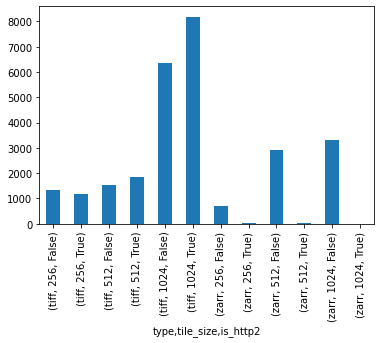

In [115]:
mean_df['blocked'].plot.bar()